## MODELAJE
---

A continuación llevaremos adelante los siguientes pasos:
- Vamos a plantear dos instancias de subdivisión de nuestras matrices en subconjuntos de test y train:
1. La primera a partir de nuestra matriz esparsa generada con `CountVectorizer`
2. La segunda a partir de nuestra matriz esparsa generada con `TF-IDF`
- En ambos casos, nuestra **variable target** será el campo `rev_score` cuya distribución de valores mantendremos estratificada

La idea es comparar una sucesión de algoritmos de clasificación aplicados sobre ambas matrices y comparar los resultados desde las metricas habituales
- Para llevar adelante este paso vamos a diseñar una función 

## Importar librerías  <a id="data"></a>

In [54]:
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
import warnings

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#Método de balance de datos
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks

#Metricas de Evaluacion de modelos
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif,RFECV,RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

# Clasificadores
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics

# Tunning modelos
!pip install hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Importancia de variables y ploteo del arbol
#from xgboost import plot_tree

# guardado del modelo
import joblib


##  División de estrategias de remuestreo
---

Los diferentes tipos de remuestreo funcionan mejor con diferentes conjuntos de datos.
Dado que nuestra intención es extraer reglas de decisión generando un árbol de decisión confiable, debemos evitar métodos que generen datos sintéticos como SMOTE.

Vamos a probar tres estrategias de remuestreo.
* __Submuestreo aleatorio - RUS:__ Submuestreo de la clase mayoritaria seleccionando muestras al azar con o sin reemplazo.
* __Random Over Sampler - ROS:__ sobremuestree la clase minoritaria seleccionando muestras al azar con reemplazo.
* __TomekLink Under Sampling:__ submuestreo al eliminar las instancias de la clase mayoritaria, lo que facilita el proceso de clasificación.

## Funciones de Modelaje  <a id="data"></a>

In [55]:
def expo_metricas(model, y_test, X_test):

    y_pred = model.predict(X_test)
    
    """Función que recibe valores de 'y' reales,
    valores de 'y' predichos y 
    devuelve metricas principales"""
    
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nAUROC:", roc_auc_score(y_test, y_pred))
    print("\nF1-Score:", f1_score(y_test, y_pred, average = 'weighted'))
    print("\nClasification Report:")
    print(metrics.classification_report(y_test, y_pred))
    print("\nMatriz de confusion:")
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='d')
    plt.show();

In [56]:
def Reduction_Data(X_train,X_test,y_train):
    skb=SelectKBest(f_classif,k=150)
    X_train_2=skb.fit_transform(X_train,y_train)
    X_test_2=X_test.loc[:,skb.get_support()]
    
    return X_train_2, X_test_2

In [57]:
# Submuestreo aleatorio

def Rus_Split(X_train, y_train): 

    rus = RandomUnderSampler()

    X_rus, y_rus  = rus.fit_resample(X_train ,  y_train)


    return X_rus, y_rus

In [58]:
# OverSampler aleatorio

def Ros_Split(X_train, y_train):
    
    ros = RandomOverSampler()

    X_ros, y_ros = ros.fit_resample(X_train, y_train)

   
    return X_ros, y_ros

In [59]:
# Under sampler TomekLinks

def Ustl_Split(X_train, y_train):
    
    tl = TomekLinks( sampling_strategy ='majority')

    X_tl, y_tl= tl.fit_resample(X_train, y_train)


    return X_tl, y_tl

In [60]:
def Model_Score(model, y_test, X_test):

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    total_score = {'Recall':[recall_score(y_test, y_pred, pos_label=1,average='binary')],
                   'Precision': [precision_score(y_test, y_pred, pos_label=1,average='binary')],
                   'F1_score' : [f1_score(y_test, y_pred, pos_label=1,average='binary')],
                   'Especificity': [recall_score(y_test, y_pred, pos_label=0,average='binary')],
                   'Area b/curva ROC': [np.round(roc_auc_score(y_test,y_proba[:,1]),4)],
                   }
    
    total_score = pd.DataFrame(total_score, columns = ['Recall','Precision','F1_score','Especificity',
                                                       'Area b/curva ROC'])   
    return total_score

In [61]:
def Models_NLP_Classification(df):
    
    y = df_train_rev['rev_score']
    
    # Data Formats splits 
        
    ## raw df - 1 
    X_train_1, X_test_1 ,y_train_1, y_test_1 = train_test_split(df, y, test_size = .3, stratify = y, random_state = 42)
    
   
    # 1 - Logistic Regression (LR) 
    # 1.1 Unbalanced

    LR_1 = LogisticRegression()
    LR_1.fit(X_train_1, y_train_1)
    LR_score_1 = Model_Score(LR_1, y_test_1, X_test_1)
    print("\nLogistic Regression - Unbalanced:")
    LR_score_1_2 = expo_metricas(LR_1, y_test_1, X_test_1)

    
    ## 1.2 - Random Under Sampling (RUS)
    X_train_2_1, y_train_2_1, = Rus_Split(X_train_1, y_train_1)
    LR_2 = LogisticRegression()
    LR_2.fit(X_train_2_1, y_train_2_1)
    LR_score_2 = Model_Score(LR_2, y_test_1, X_test_1)
    print("\nLogistic Regression - Random Under Sampling:")
    LR_score_2_2 = expo_metricas(LR_2, y_test_1, X_test_1)
   
    
    ## 1.3 - Random Over Sample (ROS)
    X_train_3_1, y_train_3_1 = Ros_Split(X_train_1, y_train_1)
    LR_3 = LogisticRegression()
    LR_3.fit(X_train_3_1, y_train_3_1)
    LR_score_3 = Model_Score(LR_3, y_test_1, X_test_1)
    print("\nLogistic Regression - Random Over Sampling:")
    LR_score_3_2 = expo_metricas(LR_3, y_test_1, X_test_1)

    
    ## 1.4 Under-sampling: Tomek Links (USTL)
    X_train_4_1, y_train_4_1 = Ustl_Split(X_train_1, y_train_1)
    LR_4 = LogisticRegression()
    LR_4.fit(X_train_4_1, y_train_4_1)
    LR_score_4 = Model_Score(LR_4, y_test_1, X_test_1)
    print("\nLogistic Regression - Tomek Links:")
    LR_score_4_2 = expo_metricas(LR_4, y_test_1, X_test_1)

    
    # 2 - Multi-Nomial Naive Bayes (MNB) 
    # 2.1 Unbalanced

    MNB_1 = MultinomialNB()
    MNB_1.fit(X_train_1.toarray(), y_train_1)
    MNB_score_1 = Model_Score(MNB_1, y_test_1, X_test_1.toarray())
    print("\nMultinomial Naive Bayes - Unbalanced:")
    MNB_score_1_2 = expo_metricas(MNB_1, y_test_1, X_test_1.toarray())
    
    ## 2.2 - Random Under Sampling (RUS)
    X_train_2_1, y_train_2_1, = Rus_Split(X_train_1, y_train_1)
    MNB_2 = MultinomialNB()
    MNB_2.fit(X_train_2_1.toarray(), y_train_2_1)
    MNB_score_2 = Model_Score(MNB_2, y_test_1, X_test_1.toarray())
    print("\nMultinomial Naive Bayes - Random Under Sampling:")
    MNB_score_2_2 = expo_metricas(MNB_2, y_test_1, X_test_1.toarray())
    
    ## 2.3 - Random Over Sample (ROS)
    X_train_3_1, y_train_3_1 = Ros_Split(X_train_1, y_train_1)
    MNB_3 = MultinomialNB()
    MNB_3.fit(X_train_3_1.toarray(), y_train_3_1)
    MNB_score_3 = Model_Score(MNB_3, y_test_1, X_test_1.toarray())
    print("\nMultinomial Naive Bayes - Random Over Sampling:")
    MNB_score_3_2 = expo_metricas(MNB_3, y_test_1, X_test_1.toarray())

    
    ## 2.4 Under-sampling: Tomek Links (USTL)
    X_train_4_1, y_train_4_1 = Ustl_Split(X_train_1, y_train_1)
    MNB_4 = MultinomialNB()
    MNB_4.fit(X_train_4_1.toarray(), y_train_4_1)
    MNB_score_4 = Model_Score(MNB_4, y_test_1, X_test_1.toarray())
    print("\nMultinomial Naive Bayes - Tomek Links:")
    MNB_score_4_2 = expo_metricas(MNB_4, y_test_1, X_test_1.toarray())
    
    
    # 3 - Ramdon Forrest  Classifier (RFC) 
    # 3.1 RFC - Unbalanced DF
    RFC_1 = RandomForestClassifier(random_state=0, max_depth=5)
    RFC_1.fit(X_train_1, y_train_1)
    RFC_score_1 = Model_Score(RFC_1, y_test_1, X_test_1)
    print("\nRandom Forest Classifier - Unbalanced:")
    RFC_score_1_2 = expo_metricas(RFC_1, y_test_1, X_test_1)
    
    
    ## 3.2 - Random Under Sampling (RUS)
    X_train_2_1, y_train_2_1, = Rus_Split(X_train_1, y_train_1)
    RFC_2 = RandomForestClassifier(class_weight='balanced', random_state=0, max_depth = 5)
    RFC_2.fit(X_train_2_1, y_train_2_1)
    RFC_score_2 = Model_Score(RFC_2, y_test_1, X_test_1)
    print("\nRandom Forest Classifier - Random Under Sampling:") 
    RFC_score_2_2 = expo_metricas(RFC_2, y_test_1, X_test_1)
   
   
    ## 3.3 - Randon Over Sample (ROS)
    X_train_3_1, y_train_3_1 = Ros_Split(X_train_1, y_train_1)
    RFC_3 = RandomForestClassifier(class_weight='balanced', random_state=0, max_depth=5)
    RFC_3.fit(X_train_3_1, y_train_3_1)
    RFC_score_3 = Model_Score(RFC_3, y_test_1, X_test_1)
    print("\nRandom Forest Classifier - Random Over Sampling:")
    RFC_score_3_2 = expo_metricas(RFC_3, y_test_1, X_test_1)


    ## 3.4 Under-sampling: Tomek Links (USTL)
    X_train_4_1, y_train_4_1 = Ustl_Split(X_train_1, y_train_1)
    RFC_4 = RandomForestClassifier(class_weight='balanced',max_depth = 5)
    RFC_4.fit(X_train_4_1, y_train_4_1)
    RFC_score_4= Model_Score(RFC_4, y_test_1, X_test_1)
    print("\nRandom Forest Classifier - Tomek Links:")
    RFC_score_4_2= expo_metricas(RFC_4, y_test_1, X_test_1)
    

    # Best F1_Score
    Score = {'Methods': ['LR - Unbalanced DF - Raw DF',
                                    'LR - RUS - Raw DF',                              
                                    'LR - ROS - Raw DF',
                                    'LR - USTL - Raw DF',
                                    'MNB - Unbalanced DF - Raw DF',
                                    'MNB - RUS - Raw DF',                              
                                    'MNB - ROS - Raw DF',
                                    'MNB - USTL - Raw DF',
                                    'RFC - Unbalanced DF - Raw DF',
                                    'RFC - RUS - Raw DF',                              
                                    'RFC - ROS - Raw DF',
                                    'RFC - USTL - Raw DF',
                                    
                                   ],
                        
                             'Recall': [LR_score_1["Recall"][0],
                                        LR_score_2["Recall"][0],
                                        LR_score_3["Recall"][0],
                                        LR_score_4["Recall"][0],
                                        MNB_score_1["Recall"][0],
                                        MNB_score_2["Recall"][0],
                                        MNB_score_3["Recall"][0],
                                        MNB_score_4["Recall"][0],
                                        RFC_score_1["Recall"][0],
                                        RFC_score_2["Recall"][0],
                                        RFC_score_3["Recall"][0],
                                        RFC_score_4["Recall"][0]
                                       ],
                          'Precision': [LR_score_1["Precision"][0],
                                        LR_score_2["Precision"][0],
                                        LR_score_3["Precision"][0],
                                        LR_score_4["Precision"][0],
                                        MNB_score_1["Precision"][0],
                                        MNB_score_2["Precision"][0],
                                        MNB_score_3["Precision"][0],
                                        MNB_score_4["Precision"][0],
                                        RFC_score_1["Precision"][0],
                                        RFC_score_2["Precision"][0],
                                        RFC_score_3["Precision"][0],
                                        RFC_score_4["Precision"][0]
                                    ],
                           'F1_Score': [LR_score_1["F1_score"][0],
                                        LR_score_2["F1_score"][0],
                                        LR_score_3["F1_score"][0],
                                        LR_score_4["F1_score"][0],
                                        MNB_score_1["F1_score"][0],
                                        MNB_score_2["F1_score"][0],
                                        MNB_score_3["F1_score"][0],
                                        MNB_score_4["F1_score"][0],
                                        RFC_score_1["F1_score"][0],
                                        RFC_score_2["F1_score"][0],
                                        RFC_score_3["F1_score"][0],
                                        RFC_score_4["F1_score"][0]
                                     ],   
                       'Especificity': [LR_score_1["Especificity"][0],
                                        LR_score_2["Especificity"][0],
                                        LR_score_3["Especificity"][0],
                                        LR_score_4["Especificity"][0],
                                        MNB_score_1["Especificity"][0],
                                        MNB_score_2["Especificity"][0],
                                        MNB_score_3["Especificity"][0],
                                        MNB_score_4["Especificity"][0],
                                        RFC_score_1["Especificity"][0],
                                        RFC_score_2["Especificity"][0],
                                        RFC_score_3["Especificity"][0],
                                        RFC_score_4["Especificity"][0]
                                    ],
                   'Area b/curva ROC': [LR_score_1["Area b/curva ROC"][0],
                                        LR_score_2["Area b/curva ROC"][0],
                                        LR_score_3["Area b/curva ROC"][0],
                                        LR_score_4["Area b/curva ROC"][0],
                                        MNB_score_1["Area b/curva ROC"][0],
                                        MNB_score_2["Area b/curva ROC"][0],
                                        MNB_score_3["Area b/curva ROC"][0],
                                        MNB_score_4["Area b/curva ROC"][0],
                                        RFC_score_1["Area b/curva ROC"][0],
                                        RFC_score_2["Area b/curva ROC"][0],
                                        RFC_score_3["Area b/curva ROC"][0],
                                        RFC_score_4["Area b/curva ROC"][0]
                                    ]
                           }
    
    score_results = pd.DataFrame(Score)

    

    return score_results



## Modelos - Count Vectorizer  <a id="data"></a>

In [62]:
# Creamos la matriz esparsa

X_count = df_train_rev_sparse


In [63]:
X_count

<52198x9190 sparse matrix of type '<class 'numpy.int64'>'
	with 362391 stored elements in Compressed Sparse Row format>


Logistic Regression - Unbalanced:

Accuracy: 0.8983397190293742

AUROC: 0.8882148196481965

F1-Score: 0.8979529424853594

Clasification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      5904
           1       0.91      0.93      0.92      9756

    accuracy                           0.90     15660
   macro avg       0.89      0.89      0.89     15660
weighted avg       0.90      0.90      0.90     15660


Matriz de confusion:


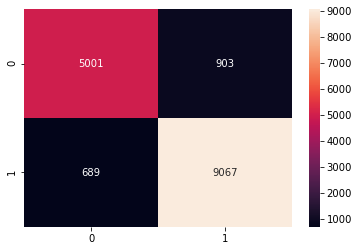


Logistic Regression - Random Under Sampling:

Accuracy: 0.89514687100894

AUROC: 0.8924736122361224

F1-Score: 0.8955443754541329

Clasification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      5904
           1       0.93      0.90      0.91      9756

    accuracy                           0.90     15660
   macro avg       0.89      0.89      0.89     15660
weighted avg       0.90      0.90      0.90     15660


Matriz de confusion:


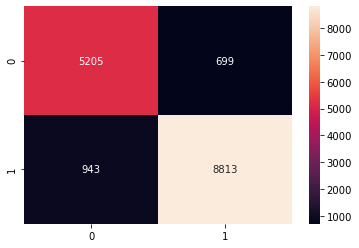


Logistic Regression - Random Over Sampling:

Accuracy: 0.8964878671775224

AUROC: 0.8924129866298662

F1-Score: 0.8967440171143325

Clasification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      5904
           1       0.92      0.91      0.92      9756

    accuracy                           0.90     15660
   macro avg       0.89      0.89      0.89     15660
weighted avg       0.90      0.90      0.90     15660


Matriz de confusion:


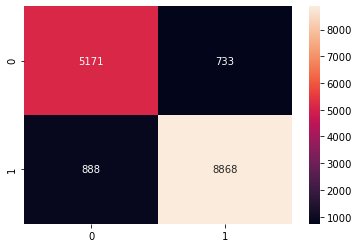


Logistic Regression - Tomek Links:

Accuracy: 0.8982120051085568

AUROC: 0.8881457564575644

F1-Score: 0.8978324090326276

Clasification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      5904
           1       0.91      0.93      0.92      9756

    accuracy                           0.90     15660
   macro avg       0.89      0.89      0.89     15660
weighted avg       0.90      0.90      0.90     15660


Matriz de confusion:


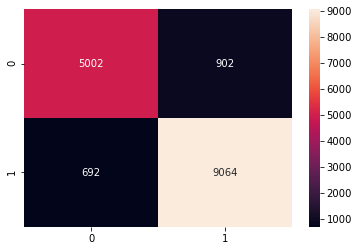


Multinomial Naive Bayes - Unbalanced:

Accuracy: 0.8893997445721583

AUROC: 0.8800031750317505

F1-Score: 0.8891381753989531

Clasification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5904
           1       0.91      0.92      0.91      9756

    accuracy                           0.89     15660
   macro avg       0.88      0.88      0.88     15660
weighted avg       0.89      0.89      0.89     15660


Matriz de confusion:


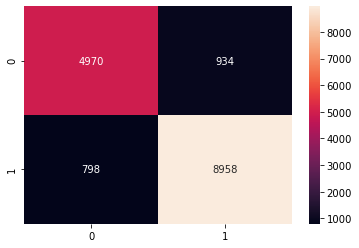


Multinomial Naive Bayes - Random Under Sampling:

Accuracy: 0.8853767560664112

AUROC: 0.8813888138881388

F1-Score: 0.8857428593692694

Clasification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      5904
           1       0.92      0.90      0.91      9756

    accuracy                           0.89     15660
   macro avg       0.88      0.88      0.88     15660
weighted avg       0.89      0.89      0.89     15660


Matriz de confusion:


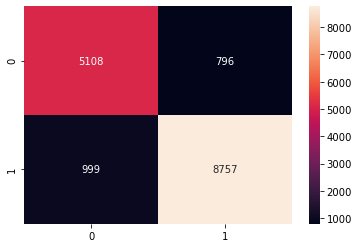


Multinomial Naive Bayes - Random Over Sampling:

Accuracy: 0.8881864623243934

AUROC: 0.8836438364383643

F1-Score: 0.8884699519906768

Clasification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      5904
           1       0.92      0.90      0.91      9756

    accuracy                           0.89     15660
   macro avg       0.88      0.88      0.88     15660
weighted avg       0.89      0.89      0.89     15660


Matriz de confusion:


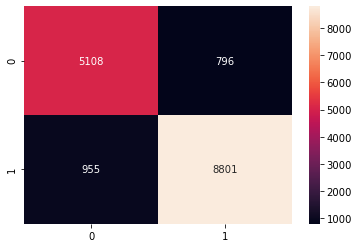


Multinomial Naive Bayes - Tomek Links:

Accuracy: 0.8895274584929758

AUROC: 0.880139113891139

F1-Score: 0.8892661913626956

Clasification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5904
           1       0.91      0.92      0.91      9756

    accuracy                           0.89     15660
   macro avg       0.88      0.88      0.88     15660
weighted avg       0.89      0.89      0.89     15660


Matriz de confusion:


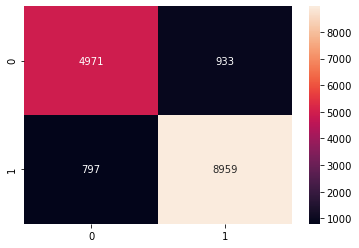


Random Forest Classifier - Unbalanced:

Accuracy: 0.6442528735632184

AUROC: 0.5283015330153301

F1-Score: 0.5251697480173797

Clasification Report:
              precision    recall  f1-score   support

           0       0.99      0.06      0.11      5904
           1       0.64      1.00      0.78      9756

    accuracy                           0.64     15660
   macro avg       0.81      0.53      0.44     15660
weighted avg       0.77      0.64      0.53     15660


Matriz de confusion:


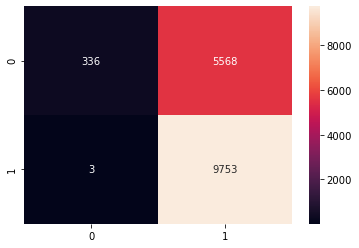


Random Forest Classifier - Random Under Sampling:

Accuracy: 0.8638569604086845

AUROC: 0.8544204192041921

F1-Score: 0.8637648445473664

Clasification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      5904
           1       0.89      0.89      0.89      9756

    accuracy                           0.86     15660
   macro avg       0.86      0.85      0.85     15660
weighted avg       0.86      0.86      0.86     15660


Matriz de confusion:


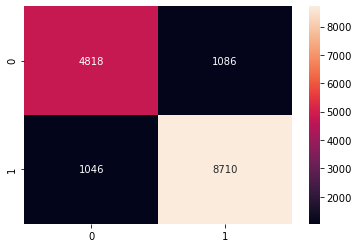


Random Forest Classifier - Random Over Sampling:

Accuracy: 0.8674968071519795

AUROC: 0.8542988554885549

F1-Score: 0.866827498616294

Clasification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      5904
           1       0.88      0.91      0.90      9756

    accuracy                           0.87     15660
   macro avg       0.86      0.85      0.86     15660
weighted avg       0.87      0.87      0.87     15660


Matriz de confusion:


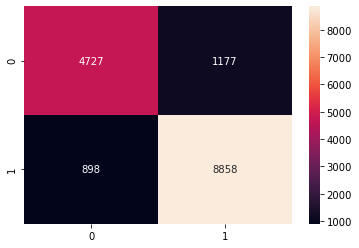


Random Forest Classifier - Tomek Links:

Accuracy: 0.8446360153256705

AUROC: 0.8276251512515126

F1-Score: 0.843411175600125

Clasification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      5904
           1       0.86      0.90      0.88      9756

    accuracy                           0.84     15660
   macro avg       0.84      0.83      0.83     15660
weighted avg       0.84      0.84      0.84     15660


Matriz de confusion:


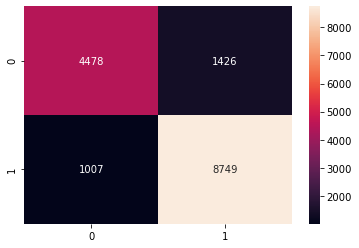

In [64]:
output_countvec = Models_NLP_Classification(X_count)

## Modelos - TF-IDF  <a id="data"></a>


Logistic Regression - Unbalanced:

Accuracy: 0.9065134099616858

AUROC: 0.9000915009150092

F1-Score: 0.9064756339635193

Clasification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5904
           1       0.92      0.93      0.93      9756

    accuracy                           0.91     15660
   macro avg       0.90      0.90      0.90     15660
weighted avg       0.91      0.91      0.91     15660


Matriz de confusion:


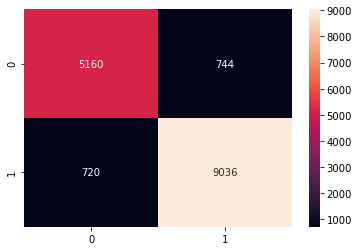


Logistic Regression - Random Under Sampling:

Accuracy: 0.9000638569604087

AUROC: 0.9014021390213902

F1-Score: 0.900737164407021

Clasification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      5904
           1       0.94      0.90      0.92      9756

    accuracy                           0.90     15660
   macro avg       0.89      0.90      0.90     15660
weighted avg       0.90      0.90      0.90     15660


Matriz de confusion:


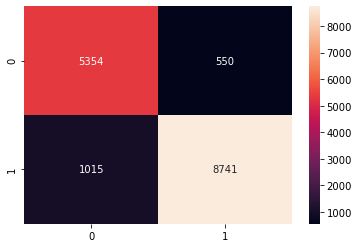


Logistic Regression - Random Over Sampling:

Accuracy: 0.9030012771392082

AUROC: 0.903291532915329

F1-Score: 0.9035640194116948

Clasification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      5904
           1       0.94      0.90      0.92      9756

    accuracy                           0.90     15660
   macro avg       0.89      0.90      0.90     15660
weighted avg       0.91      0.90      0.90     15660


Matriz de confusion:


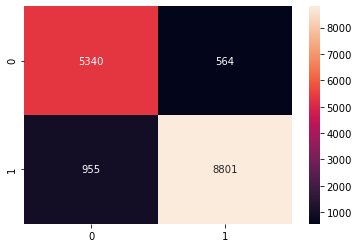


Logistic Regression - Tomek Links:

Accuracy: 0.9068326947637293

AUROC: 0.9010499479994801

F1-Score: 0.9068528672041747

Clasification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5904
           1       0.93      0.92      0.93      9756

    accuracy                           0.91     15660
   macro avg       0.90      0.90      0.90     15660
weighted avg       0.91      0.91      0.91     15660


Matriz de confusion:


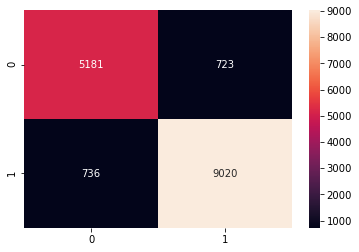


Multinomial Naive Bayes - Unbalanced:

Accuracy: 0.894955300127714

AUROC: 0.8889092015920159

F1-Score: 0.8950298685457332

Clasification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5904
           1       0.92      0.91      0.92      9756

    accuracy                           0.89     15660
   macro avg       0.89      0.89      0.89     15660
weighted avg       0.90      0.89      0.90     15660


Matriz de confusion:


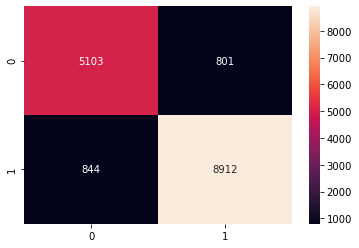


Multinomial Naive Bayes - Random Under Sampling:

Accuracy: 0.8865261813537676

AUROC: 0.8901357763577638

F1-Score: 0.8875348569992866

Clasification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86      5904
           1       0.94      0.88      0.91      9756

    accuracy                           0.89     15660
   macro avg       0.88      0.89      0.88     15660
weighted avg       0.89      0.89      0.89     15660


Matriz de confusion:


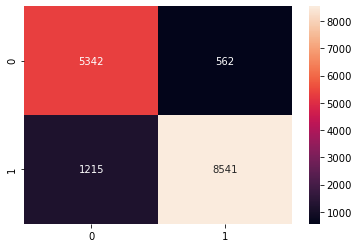


Multinomial Naive Bayes - Random Over Sampling:

Accuracy: 0.8874840357598979

AUROC: 0.8908042205422054

F1-Score: 0.8884589462108555

Clasification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      5904
           1       0.94      0.88      0.91      9756

    accuracy                           0.89     15660
   macro avg       0.88      0.89      0.88     15660
weighted avg       0.89      0.89      0.89     15660


Matriz de confusion:


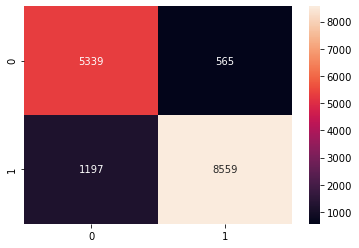


Multinomial Naive Bayes - Tomek Links:

Accuracy: 0.8954661558109834

AUROC: 0.8899210867108672

F1-Score: 0.8955876690129952

Clasification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      5904
           1       0.92      0.91      0.92      9756

    accuracy                           0.90     15660
   macro avg       0.89      0.89      0.89     15660
weighted avg       0.90      0.90      0.90     15660


Matriz de confusion:


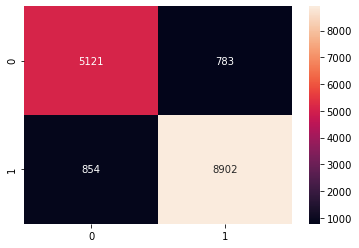


Random Forest Classifier - Unbalanced:

Accuracy: 0.6491698595146871

AUROC: 0.5351569140691407

F1-Score: 0.5362787805936398

Clasification Report:
              precision    recall  f1-score   support

           0       0.97      0.07      0.13      5904
           1       0.64      1.00      0.78      9756

    accuracy                           0.65     15660
   macro avg       0.81      0.54      0.46     15660
weighted avg       0.76      0.65      0.54     15660


Matriz de confusion:


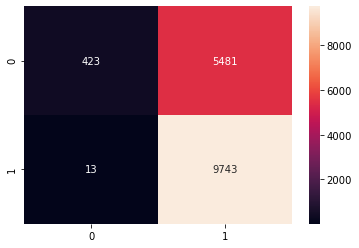


Random Forest Classifier - Random Under Sampling:

Accuracy: 0.8717113665389528

AUROC: 0.8635664481644818

F1-Score: 0.871726349680507

Clasification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      5904
           1       0.90      0.90      0.90      9756

    accuracy                           0.87     15660
   macro avg       0.86      0.86      0.86     15660
weighted avg       0.87      0.87      0.87     15660


Matriz de confusion:


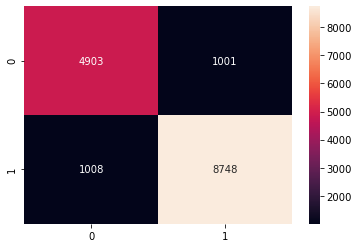


Random Forest Classifier - Random Over Sampling:

Accuracy: 0.864176245210728

AUROC: 0.8584551470514704

F1-Score: 0.8645656501093387

Clasification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      5904
           1       0.90      0.88      0.89      9756

    accuracy                           0.86     15660
   macro avg       0.85      0.86      0.86     15660
weighted avg       0.87      0.86      0.86     15660


Matriz de confusion:


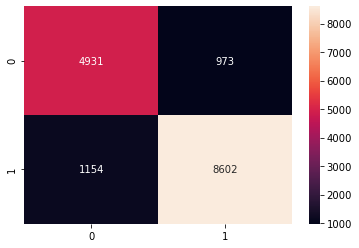


Random Forest Classifier - Tomek Links:

Accuracy: 0.8515964240102171

AUROC: 0.8438781262812628

F1-Score: 0.8518605985460256

Clasification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81      5904
           1       0.89      0.88      0.88      9756

    accuracy                           0.85     15660
   macro avg       0.84      0.84      0.84     15660
weighted avg       0.85      0.85      0.85     15660


Matriz de confusion:


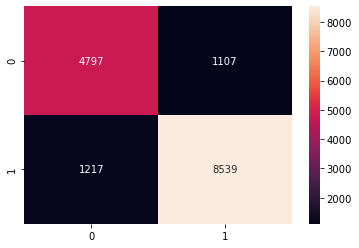

In [65]:
output_tfidf = Models_NLP_Classification(X_tfidf)

## Resumen  <a id="data"></a>

- Observamos los resultados de ambos tipos de modelo y creamos un df para compararlos

In [66]:
output_countvec

Methods    Recall  Precision  F1_Score  Especificity  \
0    LR - Unbalanced DF - Raw DF  0.929377   0.909428  0.919294      0.847053   
1              LR - RUS - Raw DF  0.903342   0.926514  0.914781      0.881606   
2              LR - ROS - Raw DF  0.908979   0.923654  0.916258      0.875847   
3             LR - USTL - Raw DF  0.929069   0.909492  0.919177      0.847222   
4   MNB - Unbalanced DF - Raw DF  0.918204   0.905580  0.911849      0.841802   
5             MNB - RUS - Raw DF  0.897601   0.916675  0.907038      0.865176   
6             MNB - ROS - Raw DF  0.902112   0.917057  0.909523      0.865176   
7            MNB - USTL - Raw DF  0.918307   0.905681  0.911950      0.841972   
8   RFC - Unbalanced DF - Raw DF  0.999692   0.636577  0.777844      0.056911   
9             RFC - RUS - Raw DF  0.892784   0.889138  0.890957      0.816057   
10            RFC - ROS - Raw DF  0.907954   0.882711  0.895154      0.800644   
11           RFC - USTL - Raw DF  0.896781   0.859853  0.877929      0.758469   

    Area b/curva ROC  
0             0.9468  
1             0.9451  
2             0.9462  
3             0.9469  
4             0.9377  
5             0.9372  
6             0.9378  
7             0.9377  
8             0.9232  
9             0.9233  
10            0.9256  
11            0.9160

In [67]:
# Columna adicional para identificar el tipo de modelo

output_countvec['Type'] = 'CountVectorizer'

In [68]:
output_countvec

Methods    Recall  Precision  F1_Score  Especificity  \
0    LR - Unbalanced DF - Raw DF  0.929377   0.909428  0.919294      0.847053   
1              LR - RUS - Raw DF  0.903342   0.926514  0.914781      0.881606   
2              LR - ROS - Raw DF  0.908979   0.923654  0.916258      0.875847   
3             LR - USTL - Raw DF  0.929069   0.909492  0.919177      0.847222   
4   MNB - Unbalanced DF - Raw DF  0.918204   0.905580  0.911849      0.841802   
5             MNB - RUS - Raw DF  0.897601   0.916675  0.907038      0.865176   
6             MNB - ROS - Raw DF  0.902112   0.917057  0.909523      0.865176   
7            MNB - USTL - Raw DF  0.918307   0.905681  0.911950      0.841972   
8   RFC - Unbalanced DF - Raw DF  0.999692   0.636577  0.777844      0.056911   
9             RFC - RUS - Raw DF  0.892784   0.889138  0.890957      0.816057   
10            RFC - ROS - Raw DF  0.907954   0.882711  0.895154      0.800644   
11           RFC - USTL - Raw DF  0.896781   0.859853  0.877929      0.758469   

    Area b/curva ROC             Type  
0             0.9468  CountVectorizer  
1             0.9451  CountVectorizer  
2             0.9462  CountVectorizer  
3             0.9469  CountVectorizer  
4             0.9377  CountVectorizer  
5             0.9372  CountVectorizer  
6             0.9378  CountVectorizer  
7             0.9377  CountVectorizer  
8             0.9232  CountVectorizer  
9             0.9233  CountVectorizer  
10            0.9256  CountVectorizer  
11            0.9160  CountVectorizer

In [69]:
# Repetimos con modelos TF-IDF

output_tfidf['Type'] = 'TF-IDF'

In [70]:
output_tfidf

Methods    Recall  Precision  F1_Score  Especificity  \
0    LR - Unbalanced DF - Raw DF  0.926199   0.923926  0.925061      0.873984   
1              LR - RUS - Raw DF  0.895961   0.940803  0.917835      0.906843   
2              LR - ROS - Raw DF  0.902112   0.939776  0.920559      0.904472   
3             LR - USTL - Raw DF  0.924559   0.925793  0.925176      0.877541   
4   MNB - Unbalanced DF - Raw DF  0.913489   0.917533  0.915507      0.864329   
5             MNB - RUS - Raw DF  0.875461   0.938262  0.905774      0.904810   
6             MNB - ROS - Raw DF  0.877306   0.938075  0.906674      0.904302   
7            MNB - USTL - Raw DF  0.912464   0.919153  0.915797      0.867378   
8   RFC - Unbalanced DF - Raw DF  0.998667   0.639976  0.780064      0.071646   
9             RFC - RUS - Raw DF  0.896679   0.897323  0.897001      0.830454   
10            RFC - ROS - Raw DF  0.881714   0.898381  0.889969      0.835196   
11           RFC - USTL - Raw DF  0.875256   0.885237  0.880219      0.812500   

    Area b/curva ROC    Type  
0             0.9546  TF-IDF  
1             0.9537  TF-IDF  
2             0.9547  TF-IDF  
3             0.9546  TF-IDF  
4             0.9473  TF-IDF  
5             0.9469  TF-IDF  
6             0.9475  TF-IDF  
7             0.9473  TF-IDF  
8             0.9278  TF-IDF  
9             0.9305  TF-IDF  
10            0.9273  TF-IDF  
11            0.9188  TF-IDF

In [71]:
# Creamos un nuevo data frame con los resultados de ambos tipos de modelo

results_summary = output_countvec

results_summary = results_summary.append(output_tfidf, ignore_index=True)

results_summary

Methods    Recall  Precision  F1_Score  Especificity  \
0    LR - Unbalanced DF - Raw DF  0.929377   0.909428  0.919294      0.847053   
1              LR - RUS - Raw DF  0.903342   0.926514  0.914781      0.881606   
2              LR - ROS - Raw DF  0.908979   0.923654  0.916258      0.875847   
3             LR - USTL - Raw DF  0.929069   0.909492  0.919177      0.847222   
4   MNB - Unbalanced DF - Raw DF  0.918204   0.905580  0.911849      0.841802   
5             MNB - RUS - Raw DF  0.897601   0.916675  0.907038      0.865176   
6             MNB - ROS - Raw DF  0.902112   0.917057  0.909523      0.865176   
7            MNB - USTL - Raw DF  0.918307   0.905681  0.911950      0.841972   
8   RFC - Unbalanced DF - Raw DF  0.999692   0.636577  0.777844      0.056911   
9             RFC - RUS - Raw DF  0.892784   0.889138  0.890957      0.816057   
10            RFC - ROS - Raw DF  0.907954   0.882711  0.895154      0.800644   
11           RFC - USTL - Raw DF  0.896781   0.859853  0.877929      0.758469   
12   LR - Unbalanced DF - Raw DF  0.926199   0.923926  0.925061      0.873984   
13             LR - RUS - Raw DF  0.895961   0.940803  0.917835      0.906843   
14             LR - ROS - Raw DF  0.902112   0.939776  0.920559      0.904472   
15            LR - USTL - Raw DF  0.924559   0.925793  0.925176      0.877541   
16  MNB - Unbalanced DF - Raw DF  0.913489   0.917533  0.915507      0.864329   
17            MNB - RUS - Raw DF  0.875461   0.938262  0.905774      0.904810   
18            MNB - ROS - Raw DF  0.877306   0.938075  0.906674      0.904302   
19           MNB - USTL - Raw DF  0.912464   0.919153  0.915797      0.867378   
20  RFC - Unbalanced DF - Raw DF  0.998667   0.639976  0.780064      0.071646   
21            RFC - RUS - Raw DF  0.896679   0.897323  0.897001      0.830454   
22            RFC - ROS - Raw DF  0.881714   0.898381  0.889969      0.835196   
23           RFC - USTL - Raw DF  0.875256   0.885237  0.880219      0.812500   

    Area b/curva ROC             Type  
0             0.9468  CountVectorizer  
1             0.9451  CountVectorizer  
2             0.9462  CountVectorizer  
3             0.9469  CountVectorizer  
4             0.9377  CountVectorizer  
5             0.9372  CountVectorizer  
6             0.9378  CountVectorizer  
7             0.9377  CountVectorizer  
8             0.9232  CountVectorizer  
9             0.9233  CountVectorizer  
10            0.9256  CountVectorizer  
11            0.9160  CountVectorizer  
12            0.9546           TF-IDF  
13            0.9537           TF-IDF  
14            0.9547           TF-IDF  
15            0.9546           TF-IDF  
16            0.9473           TF-IDF  
17            0.9469           TF-IDF  
18            0.9475           TF-IDF  
19            0.9473           TF-IDF  
20            0.9278           TF-IDF  
21            0.9305           TF-IDF  
22            0.9273           TF-IDF  
23            0.9188           TF-IDF


- Observamos los mejores resultados para cada metrica

In [72]:
# Mejor Recall

results_summary.loc[results_summary.Recall.idxmax(), :]

Methods             RFC - Unbalanced DF - Raw DF
Recall                                  0.999692
Precision                               0.636577
F1_Score                                0.777844
Especificity                           0.0569106
Area b/curva ROC                          0.9232
Type                             CountVectorizer
Name: 8, dtype: object

In [73]:
# Mejor Precision

results_summary.loc[results_summary.Precision.idxmax(), :]

Methods             LR - RUS - Raw DF
Recall                       0.895961
Precision                    0.940803
F1_Score                     0.917835
Especificity                 0.906843
Area b/curva ROC               0.9537
Type                           TF-IDF
Name: 13, dtype: object

In [74]:
# Mejor F1

results_summary.loc[results_summary.F1_Score.idxmax(), :]

Methods             LR - USTL - Raw DF
Recall                        0.924559
Precision                     0.925793
F1_Score                      0.925176
Especificity                  0.877541
Area b/curva ROC                0.9546
Type                            TF-IDF
Name: 15, dtype: object

In [75]:
# Mejor Specifity

results_summary.loc[results_summary.Especificity.idxmax(), :]

Methods             LR - RUS - Raw DF
Recall                       0.895961
Precision                    0.940803
F1_Score                     0.917835
Especificity                 0.906843
Area b/curva ROC               0.9537
Type                           TF-IDF
Name: 13, dtype: object

In [76]:
# Mejor ROC

results_summary.loc[results_summary['Area b/curva ROC'].idxmax(), :]

Methods             LR - ROS - Raw DF
Recall                       0.902112
Precision                    0.939776
F1_Score                     0.920559
Especificity                 0.904472
Area b/curva ROC               0.9547
Type                           TF-IDF
Name: 14, dtype: object

- Ordenamos el df de acuerdo al F1 score

In [77]:
results_summary.sort_values('F1_Score', ascending=False)

Methods    Recall  Precision  F1_Score  Especificity  \
15            LR - USTL - Raw DF  0.924559   0.925793  0.925176      0.877541   
12   LR - Unbalanced DF - Raw DF  0.926199   0.923926  0.925061      0.873984   
14             LR - ROS - Raw DF  0.902112   0.939776  0.920559      0.904472   
0    LR - Unbalanced DF - Raw DF  0.929377   0.909428  0.919294      0.847053   
3             LR - USTL - Raw DF  0.929069   0.909492  0.919177      0.847222   
13             LR - RUS - Raw DF  0.895961   0.940803  0.917835      0.906843   
2              LR - ROS - Raw DF  0.908979   0.923654  0.916258      0.875847   
19           MNB - USTL - Raw DF  0.912464   0.919153  0.915797      0.867378   
16  MNB - Unbalanced DF - Raw DF  0.913489   0.917533  0.915507      0.864329   
1              LR - RUS - Raw DF  0.903342   0.926514  0.914781      0.881606   
7            MNB - USTL - Raw DF  0.918307   0.905681  0.911950      0.841972   
4   MNB - Unbalanced DF - Raw DF  0.918204   0.905580  0.911849      0.841802   
6             MNB - ROS - Raw DF  0.902112   0.917057  0.909523      0.865176   
5             MNB - RUS - Raw DF  0.897601   0.916675  0.907038      0.865176   
18            MNB - ROS - Raw DF  0.877306   0.938075  0.906674      0.904302   
17            MNB - RUS - Raw DF  0.875461   0.938262  0.905774      0.904810   
21            RFC - RUS - Raw DF  0.896679   0.897323  0.897001      0.830454   
10            RFC - ROS - Raw DF  0.907954   0.882711  0.895154      0.800644   
9             RFC - RUS - Raw DF  0.892784   0.889138  0.890957      0.816057   
22            RFC - ROS - Raw DF  0.881714   0.898381  0.889969      0.835196   
23           RFC - USTL - Raw DF  0.875256   0.885237  0.880219      0.812500   
11           RFC - USTL - Raw DF  0.896781   0.859853  0.877929      0.758469   
20  RFC - Unbalanced DF - Raw DF  0.998667   0.639976  0.780064      0.071646   
8   RFC - Unbalanced DF - Raw DF  0.999692   0.636577  0.777844      0.056911   

    Area b/curva ROC             Type  
15            0.9546           TF-IDF  
12            0.9546           TF-IDF  
14            0.9547           TF-IDF  
0             0.9468  CountVectorizer  
3             0.9469  CountVectorizer  
13            0.9537           TF-IDF  
2             0.9462  CountVectorizer  
19            0.9473           TF-IDF  
16            0.9473           TF-IDF  
1             0.9451  CountVectorizer  
7             0.9377  CountVectorizer  
4             0.9377  CountVectorizer  
6             0.9378  CountVectorizer  
5             0.9372  CountVectorizer  
18            0.9475           TF-IDF  
17            0.9469           TF-IDF  
21            0.9305           TF-IDF  
10            0.9256  CountVectorizer  
9             0.9233  CountVectorizer  
22            0.9273           TF-IDF  
23            0.9188           TF-IDF  
11            0.9160  CountVectorizer  
20            0.9278           TF-IDF  
8             0.9232  CountVectorizer

- Notamos que en todos los casos, la diferencia entre aplicar `Bag of Words`y `TF-IDF` es muy escueta
- Todos los modelos mostraron mejores métricas con `TF-IDF`
- El mejor modelo fué la **Regresión Logística** con las siguientes métricas:
1. **Recall:** 0.94
2. **F1-Score:** 0.93
3. **ROC-AUC:** 0.94

---
---

## Análisis de Frases Más Comunes  <a id="data"></a>

- Identificamos las 20 frases de tres palabras con mayor indice de frecuencia en cada clase

In [78]:
vectorizer=CountVectorizer(stop_words=stopwords_por_stem,ngram_range=(3,3));

clases=['positivo', 'negativo'];

for clase in range(0,2):
    X=vectorizer.fit_transform(df_train_rev[df_train_rev['rev_score']==clase]['review']); # generamos matriz X
    counts=X.sum(axis=0); # sumamos filas de X (nos devuelve una matríz de 1 dimension * qº de palabras existentes)
    counts=np.array(counts); # pasamos de matriz de 1 * qº de terminos a array de mismas dimensiones
    
    indices=np.argsort(counts); #  ordenamos indices de menor a mayor (posiciones en el vector)
    valores=np.sort(counts); # ordenamos valores de menor a mayor (frecuencia de las cuentas)
    indices=indices[0][::-1]; # damos vuelta para obtener orden de mayor a menor
    valores=valores[0][::-1]; # damos vuelta para obtener orden de mayor a menor
    terms=np.array(vectorizer.get_feature_names()); # nombrs de las features/terminos

    print('\n Clase ', clases[clase-1])
    print(terms[indices[:20]]) # 20 indices mas frecuentes


 Clase  negativo
['não recebi produto' 'ainda não recebi' 'produto não entregue'
 'nao recebi produto' 'produto não chegou' 'produto ainda não'
 'ainda não chegou' 'momento não recebi' 'agora não recebi'
 'ainda não entregue' 'recebi produto não' 'comprei dois produtos'
 'quero dinheiro volta' 'ainda nao recebi' 'não obtive resposta'
 'recebi produto ainda' 'produto veio defeito' 'não recebi pedido'
 'não recebi ainda' 'comprei duas unidades']

 Clase  positivo
['chegou antes prazo' 'bem antes prazo' 'entregue antes prazo'
 'produto muito bom' 'chegou bem antes' 'entrega antes prazo'
 'produto chegou antes' 'produto entregue antes' 'entrega super rápida'
 'muito bom produto' 'antes prazo previsto' 'produto ótima qualidade'
 'antes prazo produto' 'muito antes prazo' 'produto boa qualidade'
 'antes data prevista' 'entregue dentro prazo' 'recebi antes prazo'
 'produto entregue prazo' 'antes prazo estipulado']


- Creamos una nube de palabras para cada clase con el objetivo de obtener insights sobre cada una

In [79]:
from wordcloud import WordCloud

In [80]:
# Definimos una función para crear las nubes 
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(30, 20))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [81]:
# Usamos Count Vectorizer para ver la frecuencia de los trigramas 
vectorizer=CountVectorizer(stop_words=stopwords_por_stem,ngram_range=(3,3));
bag_of_words = vectorizer.fit_transform(df_train_rev[df_train_rev['rev_score']==1]['review'])
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_dict = dict(words_freq)

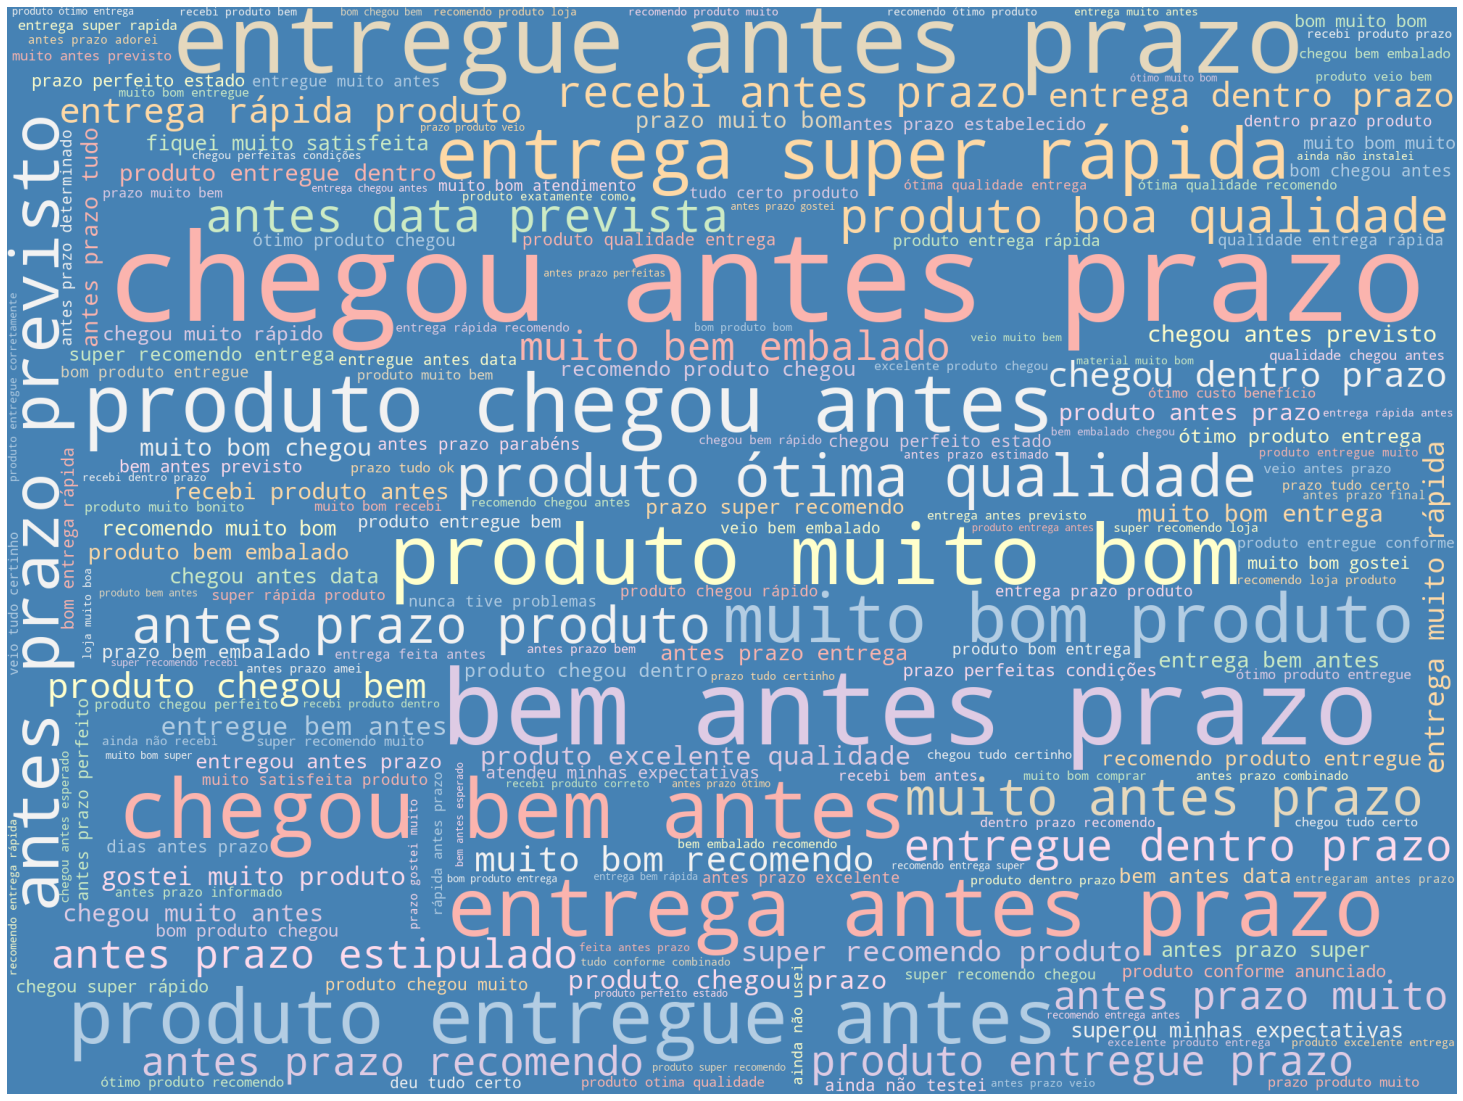

In [82]:
# Creamos la nube de palabras para la clase positiva

wordcloud_positivo = WordCloud(width = 2000, height = 1500, 
                      random_state=1, background_color='steelblue', 
                      colormap='Pastel1').generate_from_frequencies(words_dict)

plot_cloud(wordcloud_positivo)

In [83]:
# Repetimos pasos con clase negativa
vectorizer=CountVectorizer(stop_words=stopwords_por_stem,ngram_range=(3,3));
bag_of_words_neg = vectorizer.fit_transform(df_train_rev[df_train_rev['rev_score']==0]['review'])
vectorizer.vocabulary_
sum_words_neg = bag_of_words_neg.sum(axis=0) 
words_freq_neg = [(word, sum_words_neg[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq_neg =sorted(words_freq_neg, key = lambda x: x[1], reverse=True)
words_dict_neg = dict(words_freq_neg)

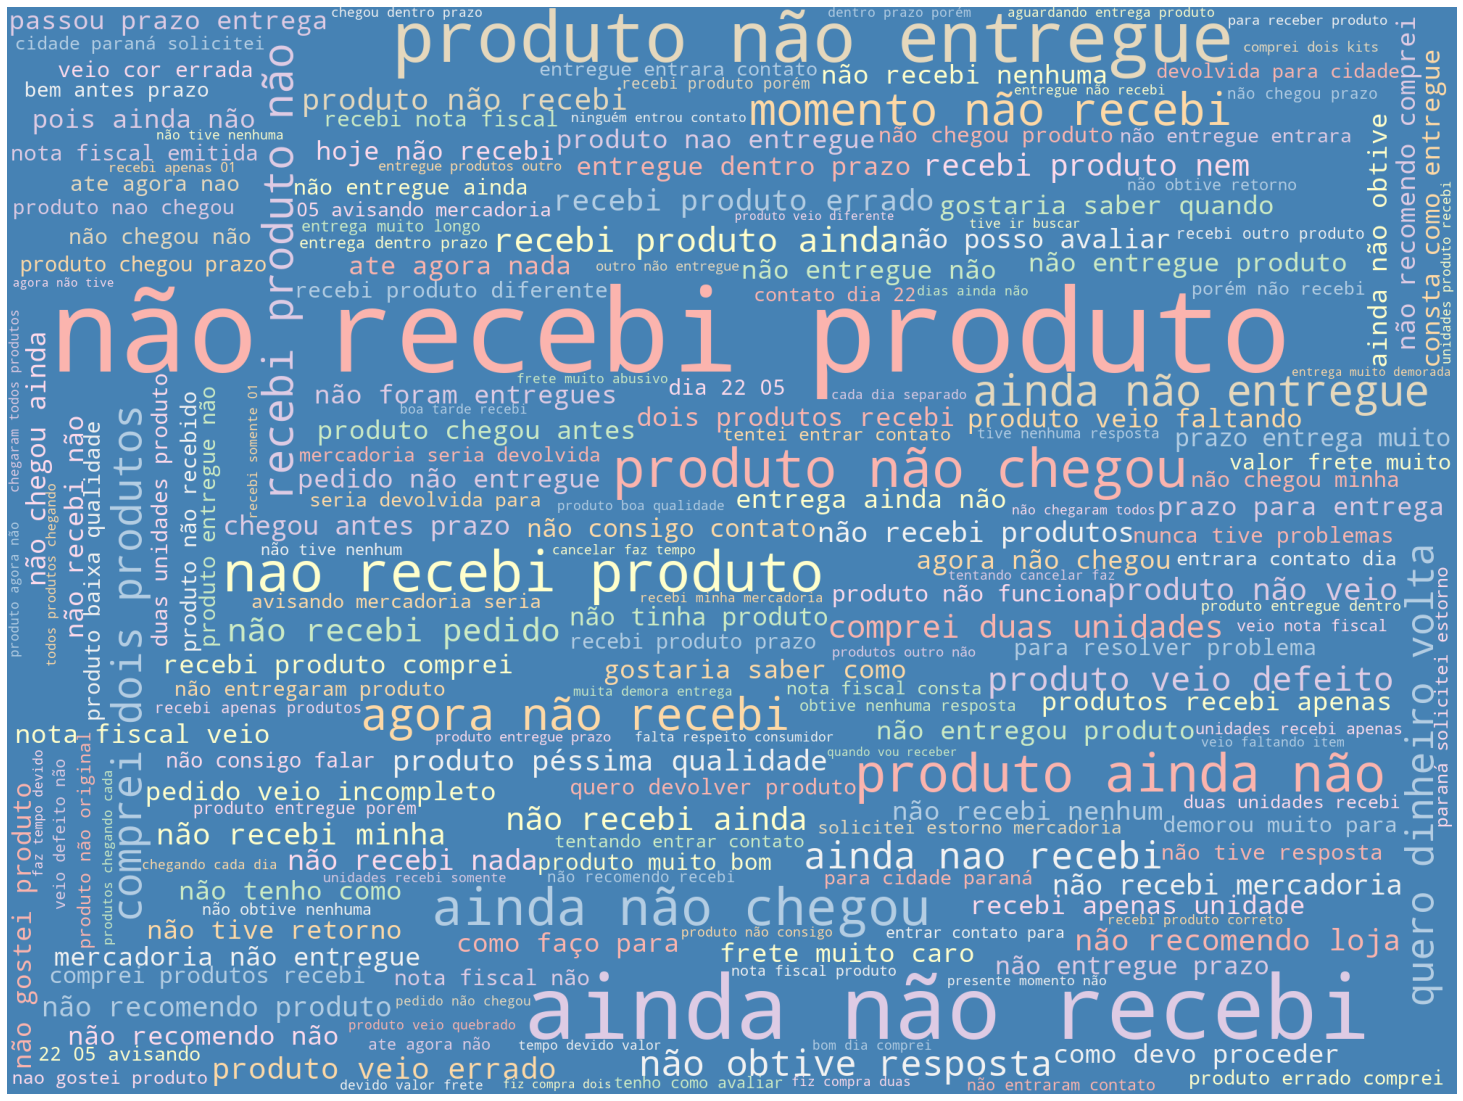

In [84]:
# Creamos la nube de palabras para la clase negativa


wordcloud_negativo = WordCloud(width = 2000, height = 1500, 
                      random_state=1, background_color='steelblue', 
                      colormap='Pastel1').generate_from_frequencies(words_dict_neg)

plot_cloud(wordcloud_negativo)

## Probamos lo mismo pero con los coeficientes de la regresión logística y 1-gramas

In [149]:
X=df_reviews.copy()

X.drop_duplicates(subset=["review_comment_title","review_comment_message"],inplace=True)
X.reset_index(drop=True, inplace=True)

y=pd.DataFrame(X.review_score>3)

X.review_comment_title.fillna(value="",inplace=True)
X.review_comment_message.fillna(value="",inplace=True)
X['review'] = X['review_comment_title'] + ' ' + X['review_comment_message'] 
tokenizer = RegexpTokenizer(r"\w+")
portugueseStemmer = SnowballStemmer('portuguese')
stopwords_por = stopwords.words('portuguese');
stopwords_por.remove('não')
stopwords_por.remove('nem')
stopwords_por_stem = [portugueseStemmer.stem(x) for x in stopwords_por]  
X = X.review.apply(lambda x: clean_review(x, tokenizer, portugueseStemmer, stopwords_por_stem))

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y)


In [150]:
vect=CountVectorizer()
tf=TfidfTransformer()
modelo=LogisticRegression()

In [151]:
X_train=vect.fit_transform(X_train)
X_train=tf.fit_transform(X_train)
reg_log=modelo.fit(X_train,y_train)

In [154]:
indices=np.argsort(reg_log.coef_)

In [158]:
texto=np.array(vect.get_feature_names())[indices][0]

coef_pos=reg_log.coef_[0][indices][0]

coef_neg=reg_log.coef_[0][indices][0]*(-1)

dict_coef_pos = dict(zip(texto, coef_pos))

coef_coef_neg = dict(zip(texto, coef_neg))


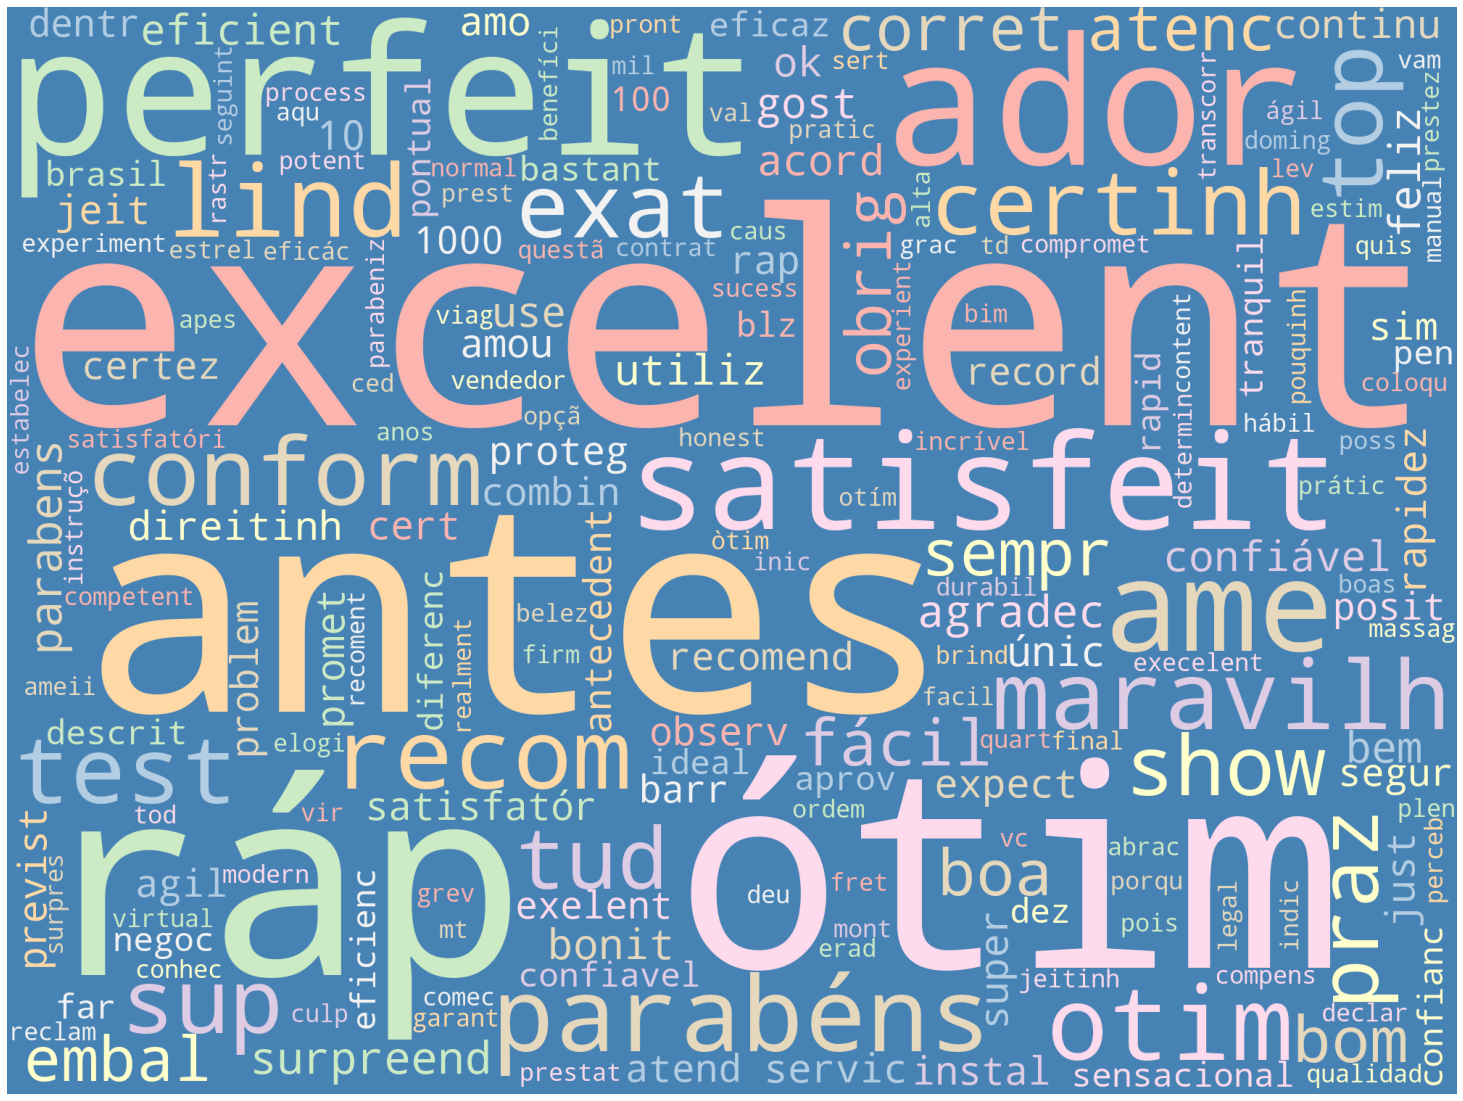

In [159]:
wordcloud_negativo = WordCloud(width = 2000,
                               height = 1500,
                               background_color='steelblue', 
                               colormap='Pastel1').generate_from_frequencies(dict_coef_pos)

plot_cloud(wordcloud_negativo)

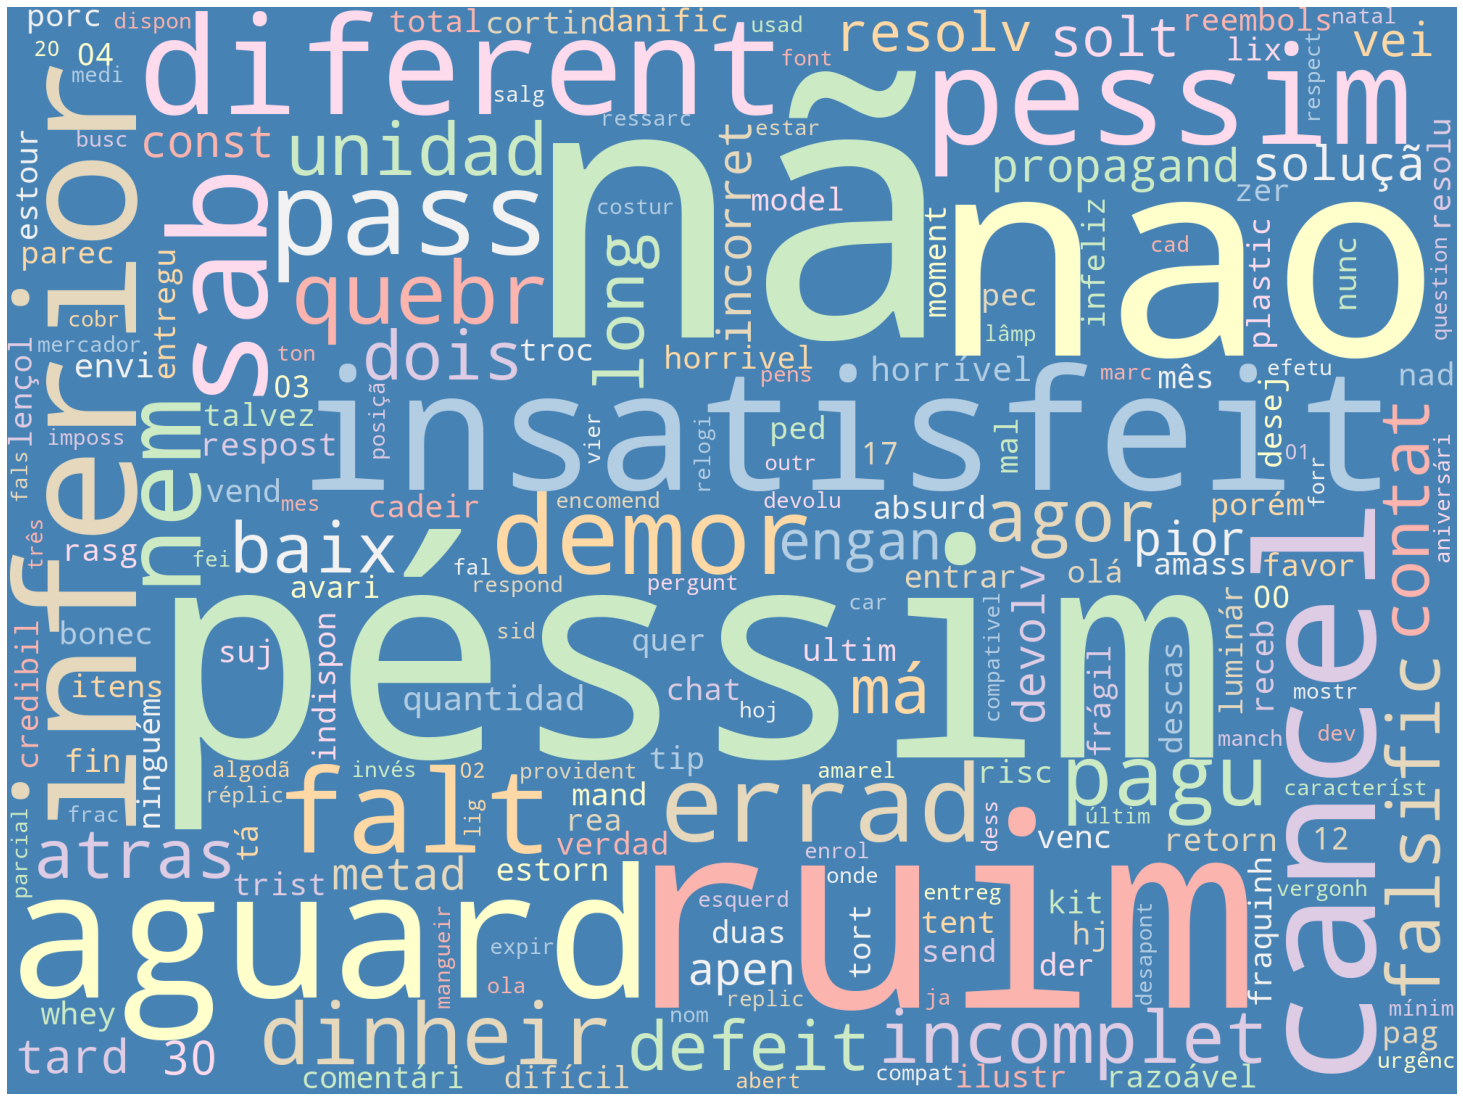

In [160]:
wordcloud_negativo = WordCloud(width = 2000,
                               height = 1500,
                               background_color='steelblue', 
                               colormap='Pastel1').generate_from_frequencies(coef_coef_neg)

plot_cloud(wordcloud_negativo)

## REDUCCIÓN DE LA DIMENSIONALIDAD:
---
- A continuación intentaremos aplicar distintas técnicas para reducir la cantidad de dimensiones disponibles en nuestras matríces 
- En primer lugar aplicaremos la técnica `TruncatedSVD`, la cuál entendemos suele estar más vinculada a problemas abordados desde TextMining
- Este transformador realiza una reducción de dimensionalidad lineal mediante descomposición en valor singular truncado (SVD). Al contrario que el PCA, este estimador no centra los datos antes de calcular la descomposición del valor singular. Esto significa que puede trabajar con matrices dispersas de manera eficiente
- Una vez instanciado dicho transformador, aplicaremos distintos modelos (`LogisticRegression` y `MultinomialNaiveBayes`) y evaluaremos sus métricas correspondientes
- Replicaremos la misma aproximación aunque sobre el set con **trigramas**
- Finalmente, aplicaremos una tecnica alternativa de reducción de dimensionalidad con **FeatureSelection** y `SelectKBest`

In [85]:
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

- Mantenemos la division de `train_test_split` correspondiente a cada matríz esparsa:
1. Matriz generada a partir de `CountVectorizer`
2. Matríz generada a partir de `TF-IDF`

In [86]:
X_count = df_train_rev_sparse
y = df_train_rev['rev_score']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_count, y, test_size = .3, stratify = y, random_state = 42) # CountVectorizer

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf, y, test_size = .3, stratify = y, random_state = 42) # TF-IFD

In [87]:
svd = TruncatedSVD();
data_componentes_cv = svd.fit_transform(df_train_rev_sparse)
data_components_cv_df = pd.DataFrame(data_componentes_cv)
data_components_cv_df = data_components_cv_df.loc[data_components_cv_df.iloc[:, 0] < 20]
data_components_cv_df.head()

0         1
0  1.177734  0.578833
1  1.177734  0.578833
2  1.177734  0.578833
3  0.911019  0.438979
4  0.840297  0.274947

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [89]:
folds = StratifiedKFold(n_splits=5,shuffle=True, random_state=42) 

In [90]:
# Inicializamos el Standard Scaler 
scl = preprocessing.StandardScaler()
#minmax = preprocessing.MinMaxScaler()

# Instanciamos un modelo de regresion logistica
lr_model = LogisticRegression()
lr_model.fit(X_train_c, y_train_c)

# Creamos un pipeline
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [91]:
# definimos el cotenido de la grilla de parámetros para GridSearchCV
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [92]:
# Inicializamos el GridSearchCV 
model_lr_c = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=None,
                                 verbose=10, n_jobs=-1, refit=True, cv=folds)

# Ajustamos el modelo de GridSearchCV a los datos de CountVectorizer
model_lr_c.fit(X_train_c, y_train_c)  # Ajustamos sobre los datos de train
print("Best score: %0.3f" % model_lr_c.best_score_)
print("Best parameters set:")
best_parameters = model_lr_c.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


Best score: 0.886
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180


- Identificamos cuál fue el mejor modelo, cuál fue su score de validación y evaluar su performance con los datos de test

In [93]:
model_lr_c.best_estimator_

Pipeline(steps=[('svd', TruncatedSVD(n_components=180)),
                ('scl', StandardScaler()), ('lr', LogisticRegression())])

In [94]:
model_lr_c.best_params_

{'lr__C': 1.0, 'lr__penalty': 'l2', 'svd__n_components': 180}

In [95]:
model_lr_c.best_score_

0.8857081321050684

In [96]:
model_lr_c.best_estimator_.score(X_test_c,y_test_c)

0.8872286079182631

#### Evaluamos en test

In [97]:
y_pred_lr_c = model_lr_c.best_estimator_.predict(X_test_c) # aplicamos todo el pipeline (y sus correspondientes transformaciones) sobre test

In [98]:
from sklearn.metrics import classification_report, accuracy_score

In [99]:
print(classification_report(y_test_c, y_pred_lr_c))
print("Exactitud del modelo:", accuracy_score(y_test_c, y_pred_lr_c))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5904
           1       0.90      0.92      0.91      9756

    accuracy                           0.89     15660
   macro avg       0.88      0.88      0.88     15660
weighted avg       0.89      0.89      0.89     15660

Exactitud del modelo: 0.8872286079182631


### TF-IDF - REGRESIÓN LOGISTICA
---

In [100]:
model_lr_tf = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=None,
                                 verbose=10, n_jobs=-1, refit=True, cv=folds)


model_lr_tf.fit(X_train_tf, y_train_tf) 
print("Best score: %0.3f" % model_lr_tf.best_score_)
print("Best parameters set:")
best_parameters = model_lr_tf.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished


Best score: 0.895
Best parameters set:
	lr__C: 10
	lr__penalty: 'l2'
	svd__n_components: 180


#### Evaluamos en test

In [101]:
y_pred_lr_tf = model_lr_tf.best_estimator_.predict(X_test_tf) # aplicamos todo el pipeline (y sus correspondientes transformaciones) sobre test

In [102]:
from sklearn.metrics import classification_report, accuracy_score

In [103]:
print(classification_report(y_test_tf, y_pred_lr_tf))
print("Exactitud:", accuracy_score(y_test_tf, y_pred_lr_tf))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5904
           1       0.92      0.92      0.92      9756

    accuracy                           0.90     15660
   macro avg       0.89      0.89      0.89     15660
weighted avg       0.90      0.90      0.90     15660

Exactitud: 0.8976372924648787


### COUNT VECTORIZER - MULTINOMIAL NAIVE BAYES
---
- Replicamos el mismo desarrollo aunque con un modelo de MultinomialNaiveBayes

In [104]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

# Creamos el pipeline
clf = pipeline.Pipeline([('nb', nb_model)])

# Creamos grilla de parámetros
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Inicializamos el modelo desde GridSearchCV
nb_model_c = GridSearchCV(estimator=clf, param_grid=param_grid,
                                 verbose=10, n_jobs=-1, refit=True, cv=folds)

# Ajustamos a los datos
nb_model_c.fit(X_train_c, y_train_c)  # Ajustamos sobre datos de train de CountVectorizer
print("Best score: %0.3f" % nb_model_c.best_score_)
print("Best parameters set:")
best_parameters = nb_model_c.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0489s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1147s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s


Best score: 0.887
Best parameters set:
	nb__alpha: 0.1


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


#### Evaluamos en test

In [105]:
y_pred_nb_c = nb_model_c.best_estimator_.predict(X_test_c) # aplicamos todo el pipeline (y sus correspondientes transformaciones) sobre test

In [106]:
from sklearn.metrics import classification_report, accuracy_score

In [107]:
print(classification_report(y_test_c, y_pred_nb_c))
print("Exactitud del modelo:", accuracy_score(y_test_c, y_pred_nb_c))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      5904
           1       0.91      0.92      0.91      9756

    accuracy                           0.89     15660
   macro avg       0.88      0.88      0.88     15660
weighted avg       0.89      0.89      0.89     15660

Exactitud del modelo: 0.8881864623243934


### TF-IDF - MULTINOMIAL NAIVE BAYES
---

In [108]:
nb_model_tf = GridSearchCV(estimator=clf, param_grid=param_grid,
                                 verbose=10, n_jobs=-1, refit=True, cv=folds)


nb_model_tf.fit(X_train_tf, y_train_tf) 
print("Best score: %0.3f" % nb_model_tf.best_score_)
print("Best parameters set:")
best_parameters = nb_model_tf.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0409s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1002s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s


Best score: 0.894
Best parameters set:
	nb__alpha: 1


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


#### Evaluamos en test

In [109]:
y_pred_nb_tf = nb_model_tf.best_estimator_.predict(X_test_tf) 

In [110]:
from sklearn.metrics import classification_report, accuracy_score

In [111]:
print(classification_report(y_test_tf, y_pred_nb_tf))
print("Exactitud del modelo:",accuracy_score(y_test_tf, y_pred_nb_tf))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5904
           1       0.92      0.91      0.92      9756

    accuracy                           0.89     15660
   macro avg       0.89      0.89      0.89     15660
weighted avg       0.90      0.89      0.90     15660

Exactitud del modelo: 0.894955300127714


---
---

## TRIGRAMAS
- Desarrollamos la misma aproximación con las matrices generadas con CountVectorizer y TF-IDF aunque incluyendo una distribución de variables por **trigramas**

In [112]:
# Probamos Count Vectorizer con trigramas

count_vectorizer_2 = CountVectorizer(strip_accents='unicode',stop_words=stopwords_por_stem,ngram_range=(3,3))
count_vectorizer_2.fit(clean_set) # fiteamos con los datos del dataset

# vectorizamos el texto
df_train_rev_sparse_2 = count_vectorizer_2.transform(clean_set) # transformamos la matriz a partir de los datos fiteados previamente
df_train_rev_sparse_2  

<52198x162769 sparse matrix of type '<class 'numpy.int64'>'
	with 285867 stored elements in Compressed Sparse Row format>

In [113]:
# Comparamos el numero de columnas contra la versión original


print('Tamaño de CountVectorizer con Unigramas:')
print(df_train_rev_sparse.shape)

print('\nTamaño de CountVectorizer con Trigramas:')
print(df_train_rev_sparse_2.shape)


Tamaño de CountVectorizer con Unigramas:
(52198, 9190)

Tamaño de CountVectorizer con Trigramas:
(52198, 162769)


In [114]:
# Probamos TF-IDF con trigramas

tfidf_vect_2 = TfidfVectorizer(ngram_range=(3,3))

X_tfidf_2 = tfidf_vect_2.fit_transform(clean_set)
X_tfidf_2

<52198x167427 sparse matrix of type '<class 'numpy.float64'>'
	with 300355 stored elements in Compressed Sparse Row format>

In [115]:
# Comparamos el numero de columnas contra la versión original

print('Tamaño de TF-IDF con Unigramas:')
print(X_tfidf.shape)

print('\nTamaño de TF-IDF con Trigramas:')
print(X_tfidf_2.shape)


Tamaño de TF-IDF con Unigramas:
(52198, 9749)

Tamaño de TF-IDF con Trigramas:
(52198, 167427)


In [116]:
X_count_2 = df_train_rev_sparse_2
y = df_train_rev['rev_score']

X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(X_count_2, y, test_size = .3, stratify = y, random_state = 42)

X_train_tf2, X_test_tf2, y_train_tf2, y_test_tf2 = train_test_split(X_tfidf_2, y, test_size = .3, stratify = y, random_state = 42)

print("Con CountVectorizer:")
display(X_train_c2.shape, X_test_c2.shape, y_train_c2.shape, y_test_c2.shape)
print("\nCon TF-IDF")
display(X_train_tf2.shape, X_test_tf2.shape, y_train_tf2.shape, y_test_tf2.shape)

Con CountVectorizer:


(36538, 162769)

(15660, 162769)

(36538,)

(15660,)


Con TF-IDF


(36538, 167427)

(15660, 167427)

(36538,)

(15660,)

In [117]:
svd = TruncatedSVD();
data_componentes_cv_2 = svd.fit_transform(df_train_rev_sparse_2)
data_components_cv_df_2 = pd.DataFrame(data_componentes_cv_2)
data_components_cv_df_2 = data_components_cv_df_2.loc[data_components_cv_df_2.iloc[:, 0] < 20]
data_components_cv_df_2.head()

0             1
0  2.415816e-04  6.266428e-04
1  2.415816e-04  6.266428e-04
2  2.415816e-04  6.266428e-04
3  1.131347e-05  7.448300e-06
4  2.967461e-14  3.286474e-15

In [118]:
scl = preprocessing.StandardScaler()

lr_model = LogisticRegression()
lr_model.fit(X_train_c2, y_train_c2)

clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [119]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [120]:
from sklearn.model_selection import GridSearchCV

### COUNT VECTORIZER - REGRESIÓN LOGISTICA
---

In [121]:
model_lr_c2 = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=None,
                                 verbose=10, n_jobs=-1, refit=True, cv=folds)


model_lr_c2.fit(X_train_c2, y_train_c2) 
print("Best score: %0.3f" % model_lr_c2.best_score_)
print("Best parameters set:")
best_parameters = model_lr_c2.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.0min finished


Best score: 0.697
Best parameters set:
	lr__C: 10
	lr__penalty: 'l2'
	svd__n_components: 180


In [122]:
y_pred_lr_c2 = model_lr_c2.best_estimator_.predict(X_test_c2) 

In [123]:
from sklearn.metrics import classification_report, accuracy_score

In [124]:
print(classification_report(y_test_c2, y_pred_lr_c2))
print("Exactitud del modelo:", accuracy_score(y_test_c2, y_pred_lr_c2))

              precision    recall  f1-score   support

           0       0.90      0.22      0.36      5904
           1       0.68      0.99      0.80      9756

    accuracy                           0.70     15660
   macro avg       0.79      0.60      0.58     15660
weighted avg       0.76      0.70      0.64     15660

Exactitud del modelo: 0.6982758620689655


In [125]:

model_lr_tf2 = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=None,
                                 verbose=10, n_jobs=-1, refit=True, cv=folds)


model_lr_tf2.fit(X_train_tf2, y_train_tf2)  
print("Best score: %0.3f" % model_lr_tf2.best_score_)
print("Best parameters set:")
best_parameters = model_lr_tf2.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.9min finished


Best score: 0.712
Best parameters set:
	lr__C: 10
	lr__penalty: 'l2'
	svd__n_components: 180


In [126]:
y_pred_lr_tf2 = model_lr_tf2.best_estimator_.predict(X_test_tf2) # aplicamos todo el pipeline (y sus correspondientes transformaciones) sobre test

In [127]:
print(classification_report(y_test_tf2, y_pred_lr_tf2))
print("Exactitud del modelo:", accuracy_score(y_test_tf2, y_pred_lr_tf2))

              precision    recall  f1-score   support

           0       0.92      0.28      0.43      5904
           1       0.69      0.98      0.81      9756

    accuracy                           0.72     15660
   macro avg       0.81      0.63      0.62     15660
weighted avg       0.78      0.72      0.67     15660

Exactitud del modelo: 0.7195402298850575


- Notamos que los resultados empeoran considerablemente si contemplamos una estructura de trigramas

## FEATURE SELECTION
---

In [128]:
from sklearn.feature_selection import SelectKBest, f_classif,RFECV,RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

In [129]:
def evaluate_model(model,X,y_true):
    '''
    Calcula las métricas ppales para evaluar un clasificador
    Toma como imput el modelo entrenado, el dataset de testeo y sus etiquetas
    '''
    y_pred=model.predict(X)
    y_proba=model.predict_proba(X)

    print(classification_report(y_true,y_pred))
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_true,y_proba[:,1]),4))
    precision, recall,threshold=precision_recall_curve(y_true,y_proba[:,1]);
    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
    plot_confusion_matrix(model,X,y_true,cmap='Blues');
    return

### Aplicamos sobre matriz esparsa generada desde CountVectorizer()
---

In [130]:
# Seleccion de features:
skf=StratifiedKFold(n_splits=3,shuffle=True,random_state=0)
steps=([('selector',SelectKBest(f_classif)),('classif',RandomForestClassifier(class_weight='balanced_subsample'))])
pipe=Pipeline(steps)
param_grid={'selector__k':np.arange(10,150,20)}
grid=GridSearchCV(pipe,param_grid,scoring='f1',cv=skf,verbose=3,n_jobs=3)
grid.fit(X_train_c,y_train_c)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  21 out of  21 | elapsed:   46.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classif',
                                        RandomForestClassifier(class_weight='balanced_subsample'))]),
             n_jobs=3,
             param_grid={'selector__k': array([ 10,  30,  50,  70,  90, 110, 130])},
             scoring='f1', verbose=3)

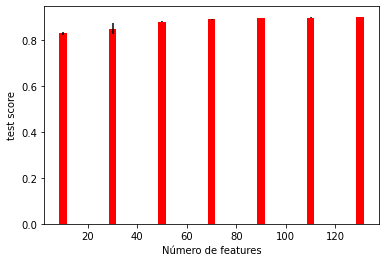

In [131]:
n_features=grid.cv_results_['param_selector__k'].data
mn_cv_score=grid.cv_results_['mean_test_score']
err=grid.cv_results_['std_test_score']
plt.bar(n_features,mn_cv_score,color = "r",width=3,yerr=err,align = "center")
plt.xlabel('Número de features')
plt.ylabel('test score');

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5904
           1       0.93      0.93      0.93      9756

    accuracy                           0.91     15660
   macro avg       0.91      0.91      0.91     15660
weighted avg       0.91      0.91      0.91     15660

Area bajo la curva ROC: 0.9592
Area bajo la curva Precision-Recall: 0.9691


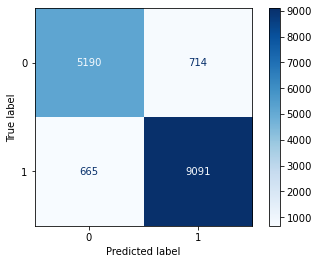

In [132]:
skb = SelectKBest(f_classif, k=70)
model_rf = RandomForestClassifier(class_weight='balanced_subsample')
model_rf.fit(X_train_c, y_train_c)
evaluate_model(model_rf, X_test_c, y_test_c)

### Aplicamos sobre matriz esparsa generada desde TF-IDF
---

In [133]:
grid.fit(X_train_tf,y_train_tf)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  21 out of  21 | elapsed:   59.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('selector', SelectKBest()),
                                       ('classif',
                                        RandomForestClassifier(class_weight='balanced_subsample'))]),
             n_jobs=3,
             param_grid={'selector__k': array([ 10,  30,  50,  70,  90, 110, 130])},
             scoring='f1', verbose=3)

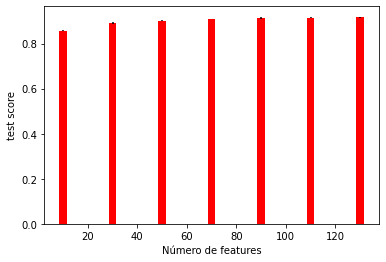

In [134]:
mn_cv_score=grid.cv_results_['mean_test_score']
err=grid.cv_results_['std_test_score']
plt.bar(n_features,mn_cv_score,color = "r",width=3,yerr=err,align = "center")
plt.xlabel('Número de features')
plt.ylabel('test score');

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      5904
           1       0.94      0.93      0.93      9756

    accuracy                           0.92     15660
   macro avg       0.91      0.92      0.91     15660
weighted avg       0.92      0.92      0.92     15660

Area bajo la curva ROC: 0.9636
Area bajo la curva Precision-Recall: 0.9719


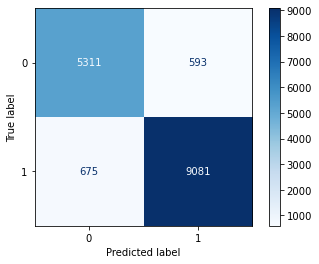

In [135]:
model_rf.fit(X_train_tf, y_train_tf)
evaluate_model(model_rf, X_test_tf, y_test_tf)

In [209]:
from sklearn.ensemble import GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.85      0.72      0.78      3832
           1       0.88      0.94      0.91      8322

    accuracy                           0.87     12154
   macro avg       0.87      0.83      0.84     12154
weighted avg       0.87      0.87      0.87     12154

Area bajo la curva ROC: 0.9262
Area bajo la curva Precision-Recall: 0.9594
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      8939
           1       0.88      0.95      0.91     19418

    accuracy                           0.88     28357
   macro avg       0.88      0.83      0.85     28357
weighted avg       0.88      0.88      0.87     28357

Area bajo la curva ROC: 0.9366
Area bajo la curva Precision-Recall: 0.9663


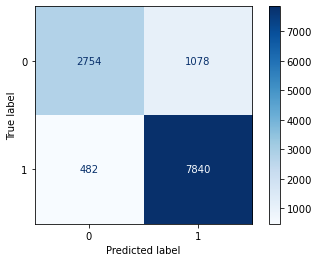

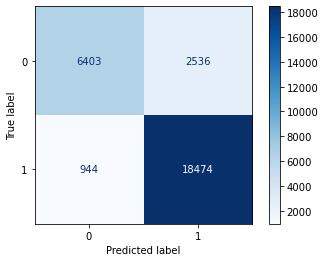

In [210]:
xgb_class = GradientBoostingClassifier(loss ='deviance',
                                       learning_rate=0.1,
                                       n_estimators = 200,
                                       subsample=1,
                                       criterion='mse')
model = xgb_class
model.fit(X_train_c, y_train_c)
evaluate_model(model, X_test_c, y_test_c)
evaluate_model(model, X_train_c, y_train_c)

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      8939
           1       0.88      0.95      0.91     19418

    accuracy                           0.88     28357
   macro avg       0.88      0.83      0.85     28357
weighted avg       0.88      0.88      0.87     28357

Area bajo la curva ROC: 0.9366
Area bajo la curva Precision-Recall: 0.9663


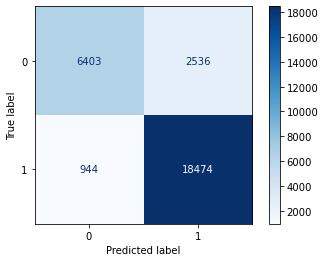

In [211]:
evaluate_model(model, X_train_c, y_train_c)

In [212]:
result_proba = model.predict_proba(X_test_c)
result_proba[:,0]

array([0.32217482, 0.04873284, 0.89329887, ..., 0.31380923, 0.25834813,
       0.14296583])

In [213]:
y_pred_custom=(result_proba[:,1]>0.5)
conf_mat = confusion_matrix(y_test_c, y_pred_custom)

TP=conf_mat[1,1]
FP=conf_mat[0,1]
TN=conf_mat[0,0]
FN=conf_mat[1,0]

accuracy=(TN+TP)/(TN+TP+FN+FP)
recall= TP /  (TP + FN)
specificity=  TN /  (TN + FP  )
precision=  TP / (TP + FP)
f1_score= 2*recall*specificity/(recall+specificity)
neg_prec=  TN / (TN + FN)

print(" ACC",accuracy,
      "\n","Recall", recall,
      "\n","Spec",specificity,
      "\n","Prec",precision,
      "\n","neg prec",neg_prec,
      "\n","F1",f1_score)

 ACC 0.8716471943393121 
 Recall 0.9420812304734438 
 Spec 0.7186847599164927 
 Prec 0.8791208791208791 
 neg prec 0.8510506798516687 
 F1 0.8153580057184


## Conclusiones

- TF-IDF performa mejor que Countvectorizer solo
- No es conveniente realizar Oversampling ni Undersampling, la clase desbalanceada funciona mejor.
- El modelo que mejor performa es Regresion Logística, Random foresty xg boost, por menor demanda de cómputo y gran performance, nos quedamos con Regresion Logística

## Pipeline final
---

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [162]:

class Fill_nan(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):

        return self

    def transform(self, X):
        X.review_comment_title.fillna(value="",inplace=True)
        X.review_comment_message.fillna(value="",inplace=True)
        return X


class Make_review(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['review'] = X['review_comment_title'] + ' ' + X['review_comment_message'] 

        return X
    
    
class Dropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.drop(inplace=True,columns=[col for col in X.columns if col not in ["review"]])
        return X

class Token(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def clean_review(review_text, tokenizer, stemmer, stopwords):    
            #tokens (eliminamos todos los signos de puntuación)
            words = tokenizer.tokenize(review_text)
            #words =  RegexpTokenizer(r"\w+")
            #print(words)   
            # stemming: raiz y minúsculas:
            # la idea es agrupar caracteres similares 
            stem_words = [stemmer.stem(x) for x in words]
            #print(stem_words)
            # eliminamos stopwords (ya pasaron por stem)
            # le pasamos los stemmer a los stopwords para aplicar proceso de eliminación
            # la idea es reducir la cantidad de palabras y así también las dimensiones de nuestro próximo dataset 
            # nos aseguramos que stemmers y stopwords coincidan
            clean_words = [x for x in stem_words if x not in stopwords]
            #print(clean_words)
    
            result = " ".join(clean_words)
    
            return(result)
        tokenizer = RegexpTokenizer(r"\w+")
        portugueseStemmer = SnowballStemmer('portuguese')
        stopwords_por = stopwords.words('portuguese');
        stopwords_por.remove('não')
        stopwords_por.remove('nem')
        stopwords_por_stem = [portugueseStemmer.stem(x) for x in stopwords_por]  
        X = X.review.apply(lambda x: clean_review(x, tokenizer, portugueseStemmer, stopwords_por_stem))
        return X

In [173]:
# Cleaning previo a Pipeline: Eliminar duplicados en Reviews (title y comment)

prueba=df_reviews.copy()

prueba.drop_duplicates(subset=["review_comment_title","review_comment_message"],inplace=True)
prueba.reset_index(drop=True, inplace=True)

y=pd.DataFrame(prueba.review_score>3)

X=prueba

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y)


In [174]:
pasos=[("fill"    ,Fill_nan()),
       ("feat_ing",Make_review()),
       ("dropper" ,Dropper()),
       ("token"   ,Token()),
       ("vect"    ,CountVectorizer()),
       ("tf-idf"  ,TfidfTransformer()),
       ("dimens"  ,TruncatedSVD()),
       ("modelo"  ,RandomForestClassifier(class_weight='balanced_subsample'))]

pipe=Pipeline(pasos)

In [175]:
param_grid = [{     
                    "vect__ngram_range"      :[(3,3),(1,1)],
                    #"dimens__n_components"   :[2,500],
                    #"modelo__penalty"        :["l2",None],
                    #"modelo__solver"         :['lbfgs',"saga"]
                }]

#Con mayor poder de computo podríamos probar otras opciones en GridSearch


folds=StratifiedKFold(n_splits=5,shuffle=True)

grid=GridSearchCV(pipe, param_grid, cv=folds)

grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('fill', Fill_nan()),
                                       ('feat_ing', Make_review()),
                                       ('dropper', Dropper()),
                                       ('token', Token()),
                                       ('vect', CountVectorizer()),
                                       ('tf-idf', TfidfTransformer()),
                                       ('dimens', TruncatedSVD()),
                                       ('modelo',
                                        RandomForestClassifier(class_weight='balanced_subsample'))]),
             param_grid=[{'vect__ngram_range': [(3, 3), (1, 1)]}])

In [176]:
print('Score:' ,grid.best_score_)
grid.best_estimator_

Score: 0.8151168922481983


Pipeline(steps=[('fill', Fill_nan()), ('feat_ing', Make_review()),
                ('dropper', Dropper()), ('token', Token()),
                ('vect', CountVectorizer()), ('tf-idf', TfidfTransformer()),
                ('dimens', TruncatedSVD()),
                ('modelo',
                 RandomForestClassifier(class_weight='balanced_subsample'))])

## CONCLUSIONES Y ANALISIS FINAL
---

- Comenzamos definiendo nuestro dataset de trabajo quedandonos con aquel que contenía los campos de valor de texto/opiniones como insúmo para nuestro analisis de sentimiento
- Una vez definido el set proseguímos con la generación del corpus de trabajo para lo cuál realizamos tareas de limpieza, tokenización, creación de nuevas variables y stematización de los tokens 
- Por otro lado, definimos la variable target como las opiniones de los usuarios contenidas en la variable `rev_score` la cuál binarizamos entre **negativas** y **positivas** asignando un 0 y 1 para evitar un analisis multi-clases
- A dicho corpus le aplicamos un proceso de **vectorización** desde `CountVectorizer()` y `TF-IDF` , tecnicas que nos permíten aplicar modelos de clasificación sobre matrices esparsas
- Sobre dichas matrices aplicamos una gama de algoritmos de clasificación diversa y evaluando las métricas habituales y comúnes en cada caso
- Cada modelo de clasificación fue probado en bases de dato originales, undersampleadas y oversampleadas
- En todo momento mantuvimos una clara delimitación entre la base en donde se aplicó `CountVectorizer()` y `TF-IDF` para poder diferenciara los resultados de cada clasificación
- En todos los casos alcanzamos mejores niveles de performance con `TF-IDF` , independientemente del algoritmo aplicado.
- Continuamos complejizando el analisis elevando la cantidad de tokens por variable (de unigramas a trigramas)
- Decidimos ilustrar la composición de cada clase (negativa y positiva) con **wordclouds**. Probablemente hubiese sido una buena decisión listar una serie de nuevos **stopwords** identificados desde dichos wordclouds y analizar la performance de los modelos suprimiendo ese ruido. Lo consideramos para una continuación del analisis.
- Habiendo obtenido resultados sumamente positivos en la sección de modelaje sobre matrices de unigramas, decidimos reducir la dimensionalidad de las matrices mediante un FeatureSelection con la técnica de `SeñectKBest` 
- Si bien los resultados fueron muy buenos, no mejoran la performance de los mismos algoritmos aplicados sobre las matrices sin over u undersamplear y con unigramas.